In [81]:
!git clone https://github.com/jdvelasq/smart-choice.git
%cd smart-choice
!python setup.py develop


Cloning into 'smart-choice'...
remote: Enumerating objects: 1508, done.
remote: Counting objects: 100% (1508/1508), done.
remote: Compressing objects: 100% (640/640), done.
remote: Total 1508 (delta 999), reused 1351 (delta 852), pack-reused 0 (from 0)
Receiving objects: 100% (1508/1508), 7.07 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (999/999), done.
/content/smart-choice/smart-choice/smart-choice/smart-choice/smart-choice/smart-choice
running develop
/usr/local/lib/python3.12/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ***********************************************************************

In [82]:
import numpy as np
import pandas as pd
from itertools import combinations
from smart_choice.decisiontree import DecisionTree
from smart_choice.datanodes import DataNodes
import matplotlib.pyplot as plt
from IPython.display import display, Image
import os

In [83]:

PROGRAM_COSTS = {
    'Kampanye Media': 2.5,
    'Program Komunitas': 1.8,
    'Subsidi Gym & Nutrisi': 0.5,
    'Aplikasi Kesehatan Kota': 0.3
}

ENGAGEMENT_PROBS = {
    'Kampanye Media': {
        'Rendah': 0.30,
        'Sedang': 0.50,
        'Tinggi': 0.20
    },
    'Program Komunitas': {
        'Rendah': 0.25,
        'Sedang': 0.35,
        'Tinggi': 0.40
    }
}

OUTCOMES = {
    'Kampanye Media': {
        'Tinggi': [
            {'prob': 0.40, 'reduction': 1500, 'change': 'Signifikan'},
            {'prob': 0.50, 'reduction': 800, 'change': 'Minor'},
            {'prob': 0.10, 'reduction': 100, 'change': 'Tidak Ada'}
        ],
        'Sedang': [
            {'prob': 0.20, 'reduction': 900, 'change': 'Signifikan'},
            {'prob': 0.60, 'reduction': 500, 'change': 'Minor'},
            {'prob': 0.20, 'reduction': 50, 'change': 'Tidak Ada'}
        ],
        'Rendah': [
            {'prob': 0.05, 'reduction': 300, 'change': 'Signifikan'},
            {'prob': 0.25, 'reduction': 150, 'change': 'Minor'},
            {'prob': 0.70, 'reduction': 0, 'change': 'Tidak Ada'}
        ]
    },
    'Program Komunitas': {
        'Tinggi': [
            {'prob': 0.60, 'reduction': 1800, 'change': 'Signifikan'},
            {'prob': 0.30, 'reduction': 1100, 'change': 'Minor'},
            {'prob': 0.10, 'reduction': 200, 'change': 'Tidak Ada'}
        ],
        'Sedang': [
            {'prob': 0.45, 'reduction': 1200, 'change': 'Signifikan'},
            {'prob': 0.45, 'reduction': 700, 'change': 'Minor'},
            {'prob': 0.10, 'reduction': 100, 'change': 'Tidak Ada'}
        ],
        'Rendah': [
            {'prob': 0.10, 'reduction': 400, 'change': 'Signifikan'},
            {'prob': 0.30, 'reduction': 200, 'change': 'Minor'},
            {'prob': 0.60, 'reduction': 0, 'change': 'Tidak Ada'}
        ]
    }
}

FIXED_OUTCOMES = {
    'Subsidi Gym & Nutrisi': 950,
    'Aplikasi Kesehatan Kota': 450
}


In [84]:
def calculate_expected_value(program_name):
    total_ev = 0
    details = []

    for engagement_level, engagement_prob in ENGAGEMENT_PROBS[program_name].items():
        outcomes = OUTCOMES[program_name][engagement_level]
        level_ev = sum(outcome['prob'] * outcome['reduction'] for outcome in outcomes)
        weighted_ev = engagement_prob * level_ev
        total_ev += weighted_ev

        details.append({
            'Keterlibatan': engagement_level,
            'P(Keterlibatan)': engagement_prob,
            'EV(Pengurangan|Keterlibatan)': level_ev,
            'Weighted EV': weighted_ev
        })

    return total_ev, details

In [85]:
def print_question_a():
    print("=" * 80)
    print("QUESTION A: NILAI HARAPAN (EXPECTED VALUE)")
    print("=" * 80)

    for program in ['Kampanye Media', 'Program Komunitas']:
        ev, details = calculate_expected_value(program)

        print(f"\n{program}:")
        print("-" * 80)
        df = pd.DataFrame(details)
        print(df.to_string(index=False))
        print(f"\nTotal Expected Value: {ev:.2f} kasus")
        print(f"Biaya Investasi: ${PROGRAM_COSTS[program]:.1f} Miliar")
        print(f"EV per Miliar $: {ev/PROGRAM_COSTS[program]:.2f} kasus")

In [86]:
def print_question_b():
    print("\n\n" + "=" * 80)
    print("QUESTION B: MENU KEPUTUSAN")
    print("=" * 80)

    ev_kampanye, _ = calculate_expected_value('Kampanye Media')
    ev_komunitas, _ = calculate_expected_value('Program Komunitas')

    menu_data = {
        'Program': ['Kampanye Media', 'Program Komunitas'],
        'Expected Value (kasus)': [ev_kampanye, ev_komunitas],
        'Biaya Investasi ($M)': [PROGRAM_COSTS['Kampanye Media'], PROGRAM_COSTS['Program Komunitas']],
        'EV per $M': [ev_kampanye/PROGRAM_COSTS['Kampanye Media'],
                      ev_komunitas/PROGRAM_COSTS['Program Komunitas']]
    }

    df = pd.DataFrame(menu_data)
    print("\n", df.to_string(index=False))

    best_idx = df['Expected Value (kasus)'].idxmax()
    print(f"\nRekomendasi berdasarkan EV tertinggi: {df.loc[best_idx, 'Program']}")
    print(f"dengan expected value {df.loc[best_idx, 'Expected Value (kasus)']:.2f} kasus")

In [87]:
def create_tree():
    nodes = DataNodes()

    # Root decision node
    nodes.add_decision(
        name="Pilihan_Program_Utama",
        branches=[
            ("Media_Campaign", 0, "Tingkat_Partisipasi_Media"),
            ("Community_Program", 0, "Tingkat_Partisipasi_Komunitas")
        ],
        maximize=True
    )

    # Media campaign engagement levels
    nodes.add_chance(
        name="Tingkat_Partisipasi_Media",
        branches=[
            ("Low", 0.30, 0, "Partisipasi_Rendah_Media"),
            ("Medium", 0.50, 0, "Partisipasi_Sedang_Media"),
            ("High", 0.20, 0, "Partisipasi_Tinggi_Media")
        ]
    )

    # High engagement outcomes for media
    nodes.add_chance(
        name="Partisipasi_Tinggi_Media",
        branches=[
            ("Significant", 0.40, 1500, "terminal_media_high_sig"),
            ("Minimal", 0.50, 800, "terminal_media_high_min"),
            ("None", 0.10, 100, "terminal_media_high_none")
        ]
    )

    # Medium engagement outcomes for media
    nodes.add_chance(
        name="Partisipasi_Sedang_Media",
        branches=[
            ("Significant", 0.20, 900, "terminal_media_med_sig"),
            ("Minimal", 0.60, 500, "terminal_media_med_min"),
            ("None", 0.20, 50, "terminal_media_med_none")
        ]
    )

    # Low engagement outcomes for media
    nodes.add_chance(
        name="Partisipasi_Rendah_Media",
        branches=[
            ("Significant", 0.05, 300, "terminal_media_low_sig"),
            ("Minimal", 0.25, 150, "terminal_media_low_min"),
            ("None", 0.70, 0, "terminal_media_low_none")
        ]
    )

    # Community program engagement levels
    nodes.add_chance(
        name="Tingkat_Partisipasi_Komunitas",
        branches=[
            ("Low", 0.25, 0, "Partisipasi_Rendah_Komunitas"),
            ("Medium", 0.35, 0, "Partisipasi_Sedang_Komunitas"),
            ("High", 0.40, 0, "Partisipasi_Tinggi_Komunitas")
        ]
    )

    # High engagement outcomes for community
    nodes.add_chance(
        name="Partisipasi_Tinggi_Komunitas",
        branches=[
            ("None", 0.10, 200, "terminal_comm_high_none"),
            ("Minimal", 0.30, 1100, "terminal_comm_high_min"),
            ("Significant", 0.60, 1800, "terminal_comm_high_sig")
        ]
    )

    # Medium engagement outcomes for community
    nodes.add_chance(
        name="Partisipasi_Sedang_Komunitas",
        branches=[
            ("Significant", 0.45, 1200, "terminal_comm_med_sig"),
            ("Minimal", 0.45, 700, "terminal_comm_med_min"),
            ("None", 0.10, 100, "terminal_comm_med_none")
        ]
    )

    # Low engagement outcomes for community
    nodes.add_chance(
        name="Partisipasi_Rendah_Komunitas",
        branches=[
            ("Significant", 0.10, 400, "terminal_comm_low_sig"),
            ("Minimal", 0.30, 200, "terminal_comm_low_min"),
            ("None", 0.60, 0, "terminal_comm_low_none")
        ]
    )

    # Terminal nodes for media campaign
    nodes.add_terminal("terminal_media_low_sig", lambda values, probabilities=None, branches=None: 300)
    nodes.add_terminal("terminal_media_low_min", lambda values, probabilities=None, branches=None: 150)
    nodes.add_terminal("terminal_media_low_none", lambda values, probabilities=None, branches=None: 0)

    nodes.add_terminal("terminal_media_med_sig", lambda values, probabilities=None, branches=None: 900)
    nodes.add_terminal("terminal_media_med_min", lambda values, probabilities=None, branches=None: 500)
    nodes.add_terminal("terminal_media_med_none", lambda values, probabilities=None, branches=None: 50)

    nodes.add_terminal("terminal_media_high_sig", lambda values, probabilities=None, branches=None: 1500)
    nodes.add_terminal("terminal_media_high_min", lambda values, probabilities=None, branches=None: 800)
    nodes.add_terminal("terminal_media_high_none", lambda values, probabilities=None, branches=None: 100)

    # Terminal nodes for community program
    nodes.add_terminal("terminal_comm_low_sig", lambda values, probabilities=None, branches=None: 400)
    nodes.add_terminal("terminal_comm_low_min", lambda values, probabilities=None, branches=None: 200)
    nodes.add_terminal("terminal_comm_low_none", lambda values, probabilities=None, branches=None: 0)

    nodes.add_terminal("terminal_comm_med_sig", lambda values, probabilities=None, branches=None: 1200)
    nodes.add_terminal("terminal_comm_med_min", lambda values, probabilities=None, branches=None: 700)
    nodes.add_terminal("terminal_comm_med_none", lambda values, probabilities=None, branches=None: 100)

    nodes.add_terminal("terminal_comm_high_sig", lambda values, probabilities=None, branches=None: 1800)
    nodes.add_terminal("terminal_comm_high_min", lambda values, probabilities=None, branches=None: 1100)
    nodes.add_terminal("terminal_comm_high_none", lambda values, probabilities=None, branches=None: 200)

    tree_media = DecisionTree(nodes=nodes)
    tree_media.evaluate()
    tree_media.rollback()

    return tree_media

In [88]:
def print_question_c():
    print("\n\n" + "=" * 80)
    print("QUESTION C: DECISION ANALYSIS DECISION TREE (DADT)")
    print("=" * 80)

    dt = create_tree()

    print("\nSTRUKTUR DAN ANALISIS DECISION TREE:")
    print("-" * 80)

    dt.evaluate()
    ev_tree = dt.rollback(view='ev')
    print(f"\nTree EV (optimal): {ev_tree:.2f} kasus")

    print("\nManual calculation for verification:")
    print("-" * 80)

    ev_km, details_km = calculate_expected_value('Kampanye Media')
    ev_pk, details_pk = calculate_expected_value('Program Komunitas')

    print("\nComparison:")
    print("-" * 80)
    comparison = pd.DataFrame({
        'Program': ['Kampanye Media', 'Program Komunitas'],
        'Tree EV': [ev_km if ev_tree < ev_pk else ev_tree, ev_pk if ev_tree >= ev_pk else ev_tree],
        'Manual EV': [ev_km, ev_pk],
        'Cost ($B)': [2.5, 1.8],
        'EV per $B': [ev_km/2.5, ev_pk/1.8]
    })
    print(comparison.to_string(index=False))


    try:
        dt.display(max_deep=2)
    except:
        pass

    png_files_before = [f for f in os.listdir('.') if f.endswith('.png')]

    try:
        result = dt.plot(policy_suggestion=False)

        png_files_after = [f for f in os.listdir('.') if f.endswith('.png')]
        new_files = [f for f in png_files_after if f not in png_files_before]

        if new_files:
            print(f"NEW PNG files created: {new_files}")
            for fname in new_files:
                full_path = os.path.abspath(fname)
                file_size = os.path.getsize(fname)

                try:
                    from IPython.display import display, Image as IPImage
                    display(IPImage(filename=fname))
                except Exception as e:
                    print(f"    Could not display: {e}")
        else:

            if result is not None:
                try:
                    from IPython.display import display
                    display(result)
                except Exception as e:
                    print(f"Could not display: {e}")

    except Exception as e:
        print(f"Error calling dt.plot(): {e}")

    print("\nFINAL RESULTS:")
    print("=" * 80)

    optimal = 'Program Komunitas' if ev_pk > ev_km else 'Kampanye Media'
    optimal_ev = max(ev_pk, ev_km)

    print(f"\nOptimal Decision: {optimal}")
    print(f"Expected Value: {optimal_ev:.2f} kasus pengurangan diabetes")
    print(f"Difference: {abs(ev_pk - ev_km):.2f} kasus")

In [89]:
def check_constraints(combo, program_names):
    total_cost = sum(PROGRAM_COSTS[p] for p in combo)
    if total_cost > 5.0:
        return False, "Budget exceeded"

    if len(combo) > 2:
        return False, "Capacity exceeded (max 2 programs)"

    if 'Subsidi Gym & Nutrisi' in combo and 'Kampanye Media' not in combo:
        return False, "Subsidi Gym requires Kampanye Media"

    if 'Kampanye Media' in combo and 'Aplikasi Kesehatan Kota' in combo:
        return False, "Cannot have both Kampanye Media and Aplikasi"

    return True, "Valid"


def calculate_combo_value(combo):
    total_value = 0

    for program in combo:
        if program in ['Kampanye Media', 'Program Komunitas']:
            ev, _ = calculate_expected_value(program)
            total_value += ev
        else:
            total_value += FIXED_OUTCOMES[program]

    return total_value


def find_optimal_combination():
    all_programs = list(PROGRAM_COSTS.keys())
    valid_combos = []

    for r in range(1, len(all_programs) + 1):
        for combo in combinations(all_programs, r):
            is_valid, reason = check_constraints(combo, all_programs)

            if is_valid:
                total_value = calculate_combo_value(combo)
                total_cost = sum(PROGRAM_COSTS[p] for p in combo)

                valid_combos.append({
                    'Programs': list(combo),
                    'Total EV': total_value,
                    'Total Cost ($M)': total_cost,
                    'EV per $M': total_value / total_cost
                })

    return valid_combos


In [90]:
def print_question_d():
    print("\n\n" + "=" * 80)
    print("QUESTION D: KOMBINASI PROGRAM OPTIMAL")
    print("=" * 80)

    print("\nKendala:")
    print("1. Anggaran maksimal: $5 Miliar")
    print("2. Kapasitas maksimal: 2 program bersamaan")
    print("3. Subsidi Gym & Nutrisi hanya bisa dipilih jika Kampanye Media dipilih")
    print("4. Kampanye Media dan Aplikasi Kesehatan tidak bisa bersamaan")

    valid_combos = find_optimal_combination()
    valid_combos_sorted = sorted(valid_combos, key=lambda x: x['Total EV'], reverse=True)

    print(f"\n\nDitemukan {len(valid_combos_sorted)} kombinasi valid:")
    print("-" * 80)

    for i, combo in enumerate(valid_combos_sorted[:10], 1):
        print(f"\n{i}. {' + '.join(combo['Programs'])}")
        print(f"   Total EV: {combo['Total EV']:.2f} kasus")
        print(f"   Total Cost: ${combo['Total Cost ($M)']:.2f} Miliar")
        print(f"   Efficiency: {combo['EV per $M']:.2f} kasus per $Miliar")

    optimal = valid_combos_sorted[0]
    print("\n\n" + "=" * 80)
    print("SOLUSI OPTIMAL:")
    print("=" * 80)
    print(f"Kombinasi: {' + '.join(optimal['Programs'])}")
    print(f"Total Estimasi Pengurangan Kasus: {optimal['Total EV']:.2f} kasus")
    print(f"Total Biaya Investasi: ${optimal['Total Cost ($M)']:.2f} Miliar")
    print(f"Efisiensi: {optimal['EV per $M']:.2f} kasus per $Miliar")




In [93]:
print_question_a()

QUESTION A: NILAI HARAPAN (EXPECTED VALUE)

Kampanye Media:
--------------------------------------------------------------------------------
Keterlibatan  P(Keterlibatan)  EV(Pengurangan|Keterlibatan)  Weighted EV
      Rendah              0.3                          52.5        15.75
      Sedang              0.5                         490.0       245.00
      Tinggi              0.2                        1010.0       202.00

Total Expected Value: 462.75 kasus
Biaya Investasi: $2.5 Miliar
EV per Miliar $: 185.10 kasus

Program Komunitas:
--------------------------------------------------------------------------------
Keterlibatan  P(Keterlibatan)  EV(Pengurangan|Keterlibatan)  Weighted EV
      Rendah             0.25                         100.0        25.00
      Sedang             0.35                         865.0       302.75
      Tinggi             0.40                        1430.0       572.00

Total Expected Value: 899.75 kasus
Biaya Investasi: $1.8 Miliar
EV per Miliar 

In [94]:
print_question_b()



QUESTION B: MENU KEPUTUSAN

           Program  Expected Value (kasus)  Biaya Investasi ($M)  EV per $M
   Kampanye Media                  462.75                   2.5 185.100000
Program Komunitas                  899.75                   1.8 499.861111

Rekomendasi berdasarkan EV tertinggi: Program Komunitas
dengan expected value 899.75 kasus




QUESTION C: DECISION ANALYSIS DECISION TREE (DADT)

STRUKTUR DAN ANALISIS DECISION TREE:
--------------------------------------------------------------------------------

Tree EV (optimal): 899.75 kasus

Manual calculation for verification:
--------------------------------------------------------------------------------

Comparison:
--------------------------------------------------------------------------------
          Program  Tree EV  Manual EV  Cost ($B)  EV per $B
   Kampanye Media   899.75     462.75        2.5 185.100000
Program Komunitas   899.75     899.75        1.8 499.861111
|
|   899.75
\------[D] #0
        | Pilihan_Program_Utama
        | Media_Campaign      0.00   462.75
        +-------------------------------[C] #1
        |                                | Tingkat_Partisipasi_Media
        |                                | Low             .3000     0.00    52.50
        |                                | Medium          .5000     0.00   490.00
        |        

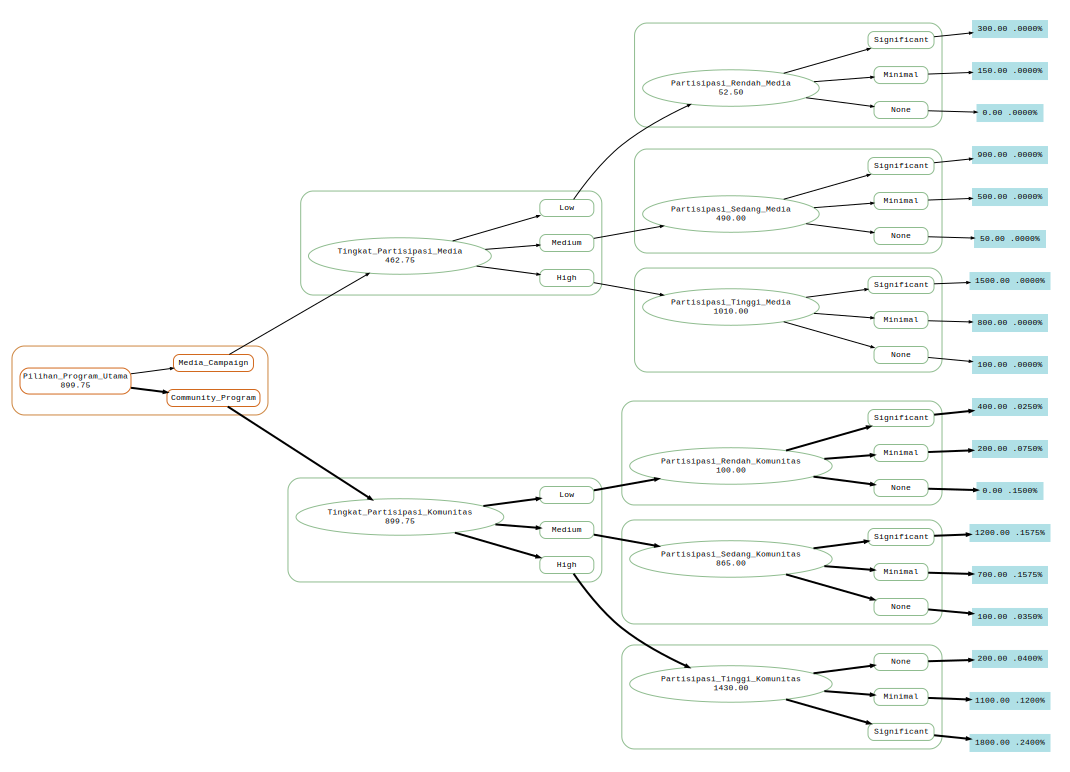




FINAL RESULTS:

Optimal Decision: Program Komunitas
Expected Value: 899.75 kasus pengurangan diabetes
Difference: 437.00 kasus


In [95]:
print_question_c()

In [96]:
print_question_d()



QUESTION D: KOMBINASI PROGRAM OPTIMAL

Kendala:
1. Anggaran maksimal: $5 Miliar
2. Kapasitas maksimal: 2 program bersamaan
3. Subsidi Gym & Nutrisi hanya bisa dipilih jika Kampanye Media dipilih
4. Kampanye Media dan Aplikasi Kesehatan tidak bisa bersamaan


Ditemukan 6 kombinasi valid:
--------------------------------------------------------------------------------

1. Kampanye Media + Subsidi Gym & Nutrisi
   Total EV: 1412.75 kasus
   Total Cost: $3.00 Miliar
   Efficiency: 470.92 kasus per $Miliar

2. Kampanye Media + Program Komunitas
   Total EV: 1362.50 kasus
   Total Cost: $4.30 Miliar
   Efficiency: 316.86 kasus per $Miliar

3. Program Komunitas + Aplikasi Kesehatan Kota
   Total EV: 1349.75 kasus
   Total Cost: $2.10 Miliar
   Efficiency: 642.74 kasus per $Miliar

4. Program Komunitas
   Total EV: 899.75 kasus
   Total Cost: $1.80 Miliar
   Efficiency: 499.86 kasus per $Miliar

5. Kampanye Media
   Total EV: 462.75 kasus
   Total Cost: $2.50 Miliar
   Efficiency: 185.10 kas